# Super resolution data preparation

Project implementing super resolution for scanned images to be used in text extraction applications such as Tesseract 4. This notebook covers data preparation.

## Setup

Read libraries and functions

In [1]:
# Plots displayed inline in notebook
%matplotlib inline

# Make help libraries available
import sys
sys.path.append('D:/anlaursen/libraries')
sys.path.append('../')

# Set visible devices, so as to just use a single GPU.
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
import urllib.request
import json
import pickle
import pandas as pd
import numpy as np
import glob

from PIL import Image
from scipy.misc import imresize

from super_resolution.address_generator import AddressGenerator
from image_augmentation.image_augmentation import Augmentor

In [3]:
PATH = '../'

## Data aquisition

Download address data

In [7]:
# All danish addresses
urllib.request.urlretrieve('http://dawa.aws.dk/adresser?format=json',
                           PATH + 'data/addresses_denmark.json')

# Copenhagen addresses
urllib.request.urlretrieve('http://dawa.aws.dk/adresser?format=json&kommunekode=0101',
                           PATH + 'data/addresses_copenhagen.json')

('../data/danmarks_adresser.json', <http.client.HTTPMessage at 0x1ee732f5e48>)

Extract address data from json

In [42]:
with open(PATH + 'data/addresses_copenhagen.json', 'rb') as f:
    json_addresses = json.loads(f.read().decode())

Extract relevant information from JSON and gather in dict with two primary lines.

In [100]:
def addr_const(in_elem):
    
    tmp_dict = {
        'road': in_elem['adgangsadresse']['vejstykke']['adresseringsnavn'],
        'number': in_elem['adgangsadresse']['husnr'],
        'floor': in_elem['etage'],
        'door': in_elem['dør'],
        'zip': in_elem['adgangsadresse']['postnummer']['nr'],
        'zip_name': in_elem['adgangsadresse']['postnummer']['navn'],
    }
    
    if tmp_dict['floor'] is not None:
        tmp_dict['floor'] = ', ' + tmp_dict['floor'] + '.'
    else:
        tmp_dict['floor'] = ''
        
    if tmp_dict['door'] is not None:
        tmp_dict['door'] = ' ' + tmp_dict['door'] + '.'
    else:
        tmp_dict['door'] = ''
        
    out_dict = {
        'road': '{tmp_dict[road]} {tmp_dict[number]}{tmp_dict[floor]}{tmp_dict[door]}'.format(tmp_dict=tmp_dict),
        'zip': '{tmp_dict[zip]} {tmp_dict[zip_name]}'.format(tmp_dict=tmp_dict)
    }
    
    return out_dict


adresses = []
for element in json_addresses:
    
    adresses.append(addr_const(element))

Save formatted address data to disk

In [104]:
with open (PATH + '/data/address_list.pkl', 'wb') as f:
    pickle.dump(addr_list, f)

Read company information

In [113]:
company_full = pd.read_csv(PATH + 'data/companies.csv', encoding = 'utf-8', low_memory = False)

companies = company_full['navn_tekst'].apply(lambda x: x.title())
companies.head(5)

companies = companies.tolist()

0                             Vognmand John Maj A/S
1             A Stoffregen Mindelegat Postboks 2231
2                    Anthon Thorup & Søn. Århus A/S
3    Finn Randrup. Tømrer- Og Snedkerforretning A/S
4                         Heka Stillads-Service A/S
Name: navn_tekst, dtype: object

Write company information to disk

In [115]:
with open (PATH + '/data/company_list.pkl', 'wb') as f:
    pickle.dump(companies, f)

Get logos, resize and dump them to disk

In [66]:
logo_files = glob.glob(PATH + 'data/logos/*.jpg')
logos = np.array([imresize(np.array(Image.open(f)), (150, 150)) for f in logo_files])

with open (PATH + '/data/logos.pkl', 'wb') as f:
    pickle.dump(logos, f)

## Image generation

Test data generation

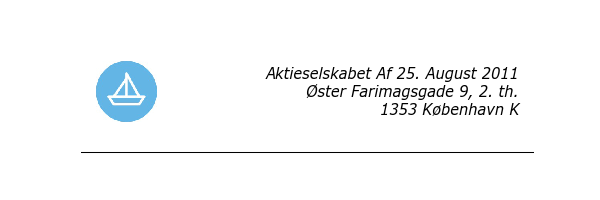

In [4]:
# Construct
addr = AddressGenerator(companies_path = PATH + '/data/company_list.pkl',
                        addresses_path = PATH + '/data/address_list.pkl',
                        logos_path = PATH + '/data/logos.pkl')

# Generate
addr.generate_header(1)

# Visualize
Image.fromarray(addr.headers_hr[0])

Test data augmentation

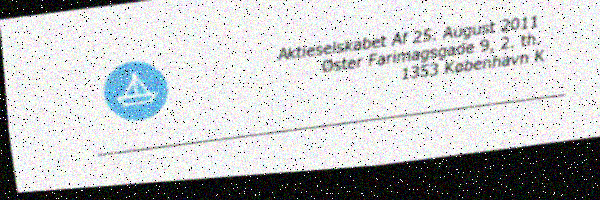

In [5]:
# Construct
augmentor = Augmentor(rotation_range = 10,
                      shear_range = 2.5,
                      shift_range = 10,
                      gaussian_blur_sd = 3,
                      gauss_noise_sd = 30,
                      salt_and_pepper_noise_intensity = 0.01,
                      rgb_color_shift = 50)

# Generate
augmented_images = augmentor.augment(addr.headers_hr)

# Visualize
Image.fromarray(augmented_images[0])